In [1]:
import pandas as pd
import json as json
from pandas import json_normalize
import os
import csv
from matplotlib import pyplot as plt

In [2]:
srcDir = "../data/preprocessed/"

In [3]:
with open(srcDir + "cleaned_data.csv", 'r') as f:
    data = list(csv.reader(f))

In [4]:
df = pd.DataFrame(data[1:], columns=data[0])
df.head()

,id,deveui,created_at,decoded_data.sensor_data.Events,decoded_data.sensor_data.Height 1,decoded_data.sensor_data.Temperature,decoded_data.sensor_data.Tilt,decoded_data.sensor_data.Tx Event
0,4110576,70B3D500700016DA,2021-05-08 20:26:00.596017,SENS_EVENT_MEASURE,112,14,1,193
1,4110093,70B3D500700016DA,2021-05-08 19:26:05.713448,SENS_EVENT_MEASURE,112,17,1,192
2,4109607,70B3D500700016DA,2021-05-08 18:25:59.323267,SENS_EVENT_MEASURE,108,15,0,191
3,4109118,70B3D500700016DA,2021-05-08 17:25:59.523137,SENS_EVENT_MEASURE,126,19,1,190
4,4108627,70B3D500700016DA,2021-05-08 16:25:59.577446,SENS_EVENT_MEASURE,118,20,0,189


In [5]:
#drop, weil nur id + externe daten übrig sein sollen

df = df.drop(columns=["decoded_data.sensor_data.Events", "decoded_data.sensor_data.Height 1", "decoded_data.sensor_data.Temperature", "decoded_data.sensor_data.Tilt", "decoded_data.sensor_data.Tx Event"])

# Relevant time period

In [6]:
from datetime import datetime

time = df["created_at"]

date = []

for x in range(1,len(time)):
    stemp = time[x].split(" ")
    date_stemp = datetime.strptime(stemp[0].replace("-", "/"), '%Y/%m/%d')
    date.append(stemp[0])
#date

In [7]:
print(min(date), " to ", max(date))

2020-05-09  to  2021-05-08


# Load holiday file

In [8]:
with open(srcDir + "holidays.csv", 'r') as f:
    holidays = list(csv.reader(f))
holidays[0]

# Ferien interessant?

['2021.01.01',
 '2021.04.02',
 '2021.04.05',
 '2021.05.01',
 '2021.05.13',
 '2021.05.24',
 '2021.06.03',
 '2021.10.03',
 '2021.12.25',
 '2021.12.26',
 '2020.01.01',
 '2020.05.01',
 '2020.10.03',
 '2020.12.25',
 '2020.12.26',
 '2020.04.10',
 '2020.04.12',
 '2020.04.13',
 '2020.05.21',
 '2020.05.31',
 '2020.06.01',
 '2020.06.11']

# Extend DataFrame and join holidays

In [9]:
df["is_holiday"] = 0

for x in range(0,len(df["created_at"])):
    date = df["created_at"][x].split(" ")[0].replace("-", ".")
    if date in holidays[0]:
        df["is_holiday"][x] = 1

<ipython-input-9-5d834490ce56>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["is_holiday"][x] = 1


In [10]:
df.head()

,id,deveui,created_at,is_holiday
0,4110576,70B3D500700016DA,2021-05-08 20:26:00.596017,0
1,4110093,70B3D500700016DA,2021-05-08 19:26:05.713448,0
2,4109607,70B3D500700016DA,2021-05-08 18:25:59.323267,0
3,4109118,70B3D500700016DA,2021-05-08 17:25:59.523137,0
4,4108627,70B3D500700016DA,2021-05-08 16:25:59.577446,0


In [11]:
df.loc[df["is_holiday"]==1]

,id,deveui,created_at,is_holiday
112,4050063,70B3D500700016DA,2021-05-01 23:26:36.559595,1
113,4049616,70B3D500700016DA,2021-05-01 22:26:36.729609,1
114,4048853,70B3D500700016DA,2021-05-01 19:26:37.281386,1
115,4048420,70B3D500700016DA,2021-05-01 18:26:35.786206,1
116,4047998,70B3D500700016DA,2021-05-01 17:26:35.994673,1
...,...,...,...,...
514814,669959,70B3D50070001789,2020-05-21 06:49:27.463635,1
514815,669713,70B3D50070001789,2020-05-21 05:49:27.638371,1
514816,669444,70B3D50070001789,2020-05-21 04:49:27.789209,1
514817,668950,70B3D50070001789,2020-05-21 02:49:34.600864,1


# Include rain per hour

In [12]:
rain_file = pd.read_csv('../data/raw/stdl_niederschlag/produkt_rr_stunde_20191130_20210601_01420.txt', delimiter=";")
rain_file = rain_file.rename(columns={"  R1": "rain (mm)"})
rain_file = rain_file.drop(columns=["STATIONS_ID", "QN_8", "RS_IND", "WRTR", "eor"])
rain_file = rain_file.astype({"MESS_DATUM": "str"})
rain_file

,MESS_DATUM,rain (mm)
0,2020050900,0.0
1,2020050901,0.0
2,2020050902,0.0
3,2020050903,0.0
4,2020050904,0.0
...,...,...
9307,2021060119,0.0
9308,2021060120,0.0
9309,2021060121,0.0
9310,2021060122,0.0


In [13]:
type(rain_file["MESS_DATUM"][0])

str

In [14]:
for x in range(len(rain_file)):
    o = rain_file["MESS_DATUM"][x]
    result = o[:4] + "-" + o[4:6] + "-" + o[6:8] + " " + o[8:]
    rain_file["MESS_DATUM"][x] = result
rain_file

<ipython-input-14-3f9d9e6f8e1c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain_file["MESS_DATUM"][x] = result


,MESS_DATUM,rain (mm)
0,2020-05-09 00,0.0
1,2020-05-09 01,0.0
2,2020-05-09 02,0.0
3,2020-05-09 03,0.0
4,2020-05-09 04,0.0
...,...,...
9307,2021-06-01 19,0.0
9308,2021-06-01 20,0.0
9309,2021-06-01 21,0.0
9310,2021-06-01 22,0.0


In [15]:
df["date_formated"] = df["created_at"].str[0:13]

In [16]:
df["date_formated"][0]

'2021-05-08 20'

In [17]:
df = df.join(rain_file.set_index('MESS_DATUM'), on='date_formated')

In [18]:
# rain file contains 69 empty or -999.0 values
# setting them to 0.0

for x in range(len(df)):
    if pd.isnull(df["rain (mm)"].iloc[x]):
        df["rain (mm)"][x] = 0.0
    else:
        if df["rain (mm)"][x] == -999.0:
            df["rain (mm)"][x] = 0.0

df

<ipython-input-18-a8d4f24ebc5f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rain (mm)"][x] = 0.0
<ipython-input-18-a8d4f24ebc5f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rain (mm)"][x] = 0.0


,id,deveui,created_at,is_holiday,date_formated,rain (mm)
0,4110576,70B3D500700016DA,2021-05-08 20:26:00.596017,0,2021-05-08 20,0.0
1,4110093,70B3D500700016DA,2021-05-08 19:26:05.713448,0,2021-05-08 19,0.0
2,4109607,70B3D500700016DA,2021-05-08 18:25:59.323267,0,2021-05-08 18,0.0
3,4109118,70B3D500700016DA,2021-05-08 17:25:59.523137,0,2021-05-08 17,0.0
4,4108627,70B3D500700016DA,2021-05-08 16:25:59.577446,0,2021-05-08 16,0.0
...,...,...,...,...,...,...
515032,598759,70B3D50070001789,2020-05-09 04:50:15.056761,0,2020-05-09 04,0.0
515033,598510,70B3D50070001789,2020-05-09 03:50:15.256986,0,2020-05-09 03,0.0
515034,598261,70B3D50070001789,2020-05-09 02:50:15.408009,0,2020-05-09 02,0.0
515035,598017,70B3D50070001789,2020-05-09 01:50:15.558981,0,2020-05-09 01,0.0


# Visualisierung des Niederschlags eines Containers

In [19]:
snapshot = df.loc[df["deveui"] == "70B3D500700016DA"]
date = snapshot["created_at"].tolist()[0:100]
rain = snapshot["rain (mm)"].tolist()[0:100]
len(date)

100

In [24]:
max(rain)

1.9

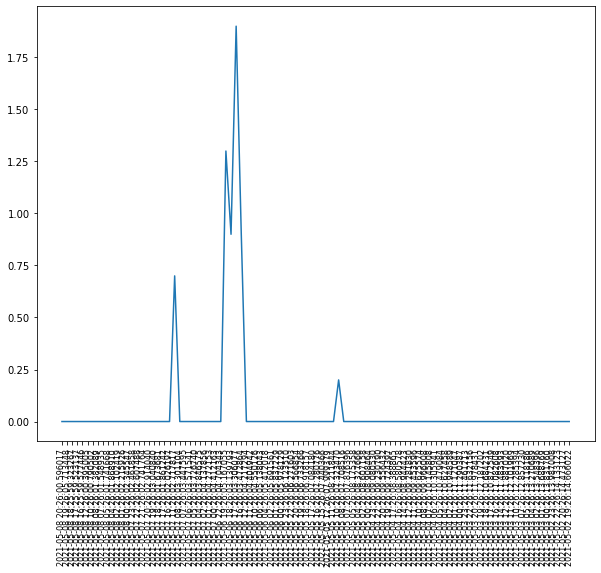

In [21]:
plt.figure(figsize=(10,8))
plt.plot(date, rain)

plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=10)

plt.show()

In [22]:
df = df.drop(columns=["created_at", "date_formated"])

In [23]:
df.to_csv(os.path.join(srcDir, "augmented_data.csv"), index=False)